This notebook contains all our scripts for the poster presentation at the NeuroAI Conference.

### Imports and Data Loading

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import BNN_Dataset, plot_loss_curves, find_argmin_in_matrix, plot_3d_scatter
from models import *
from train import train_mlp, eval_mlp, train_rnn, eval_rnn

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [2]:
# stim_times: index at which stimulation occurred 
# ephys_array: array of Neurons_x_Samples (units = # of spikes) 
# img_array:  array of Neurons_x_Samples (units = dFF)
# stim_ID: Identity of a given stim (a = forward, b = reverse, c = random) 
# each index is 33ms

'''
3s after each stimulation, 100ms time bins
input summed dF/F
spikes 100ms

# 1 how well can we predict endogenous to endogenous: 3s after onset, -100 to +100 ms bins spikes as output.
    potential issue: Ca2+ decay issue! Temporal decorrelation by binarising at each onset time?
# 2 endogenous to stimulations: 30ms bins.

Off-target problems?
Recurrent networks?
'''

stim_time = np.load('./data/biological/stim_times.npy') # (300,)
ephys_array = np.load('./data/biological/ephys_array.npy') # (77, 94357)
img_array = np.load('./data/biological/img_array.npy') # (384, 94357)
stim_id = np.load('./data/biological/stim_ID.npy') # (300,)

n_neurons, total_time = ephys_array.shape
n_stims = stim_time.shape[0]

In [3]:
from utils import rbf_rate_convolution_2d
ephys_rates = rbf_rate_convolution_2d(ephys_array.T, sigma=0.1).T # [94257, 77]

# pad
one_sided_padding_steps = int((total_time - ephys_rates.shape[0]) / 2)
one_sided_paddings = torch.zeros(one_sided_padding_steps, int(ephys_rates.shape[1]))
ephys_rates = torch.vstack((one_sided_paddings,ephys_rates))
ephys_rates = torch.vstack((ephys_rates, one_sided_paddings))

img_array = img_array.T

assert ephys_rates.shape[0] == total_time
assert img_array.shape[0] == ephys_rates.shape[0]

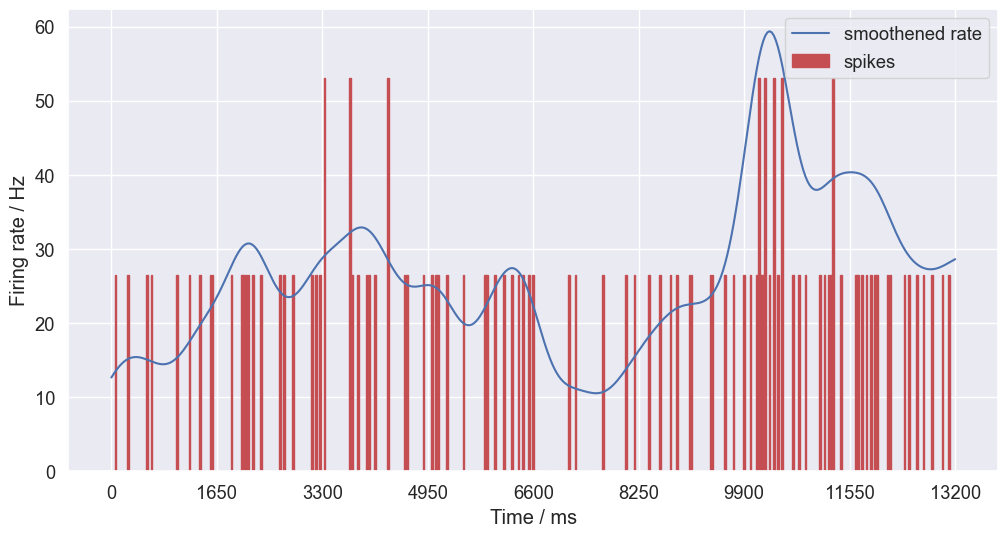

In [4]:
# plot a sample of ephys smooth rates
plt.figure(figsize=(12,6))
plt.plot(ephys_rates[50000:50401,15], label='smoothened rate')
plt.xticks(np.arange(0,401,50), [i*33 for i in range(0, 401, 50)])
plt.bar(np.arange(401), height = ephys_array[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

### Data Pre-processing
Process all input (GCaMP) data into independent tensors of length 15 (time steps) x 387 (input neurons) <br>
Process all output (EPhys) data into independent vectors of length 1 (time step) x 77 (output neurons)
The offset between input and output is -4 steps, found earlier by GLM. This is because there is a time delay in fluorescence decay.

In [5]:
tsteps = 15
cutoff_size = 4

assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [6]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

### Train for LS neurons only

In [7]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
# valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt: <br>
<ol>
  <li>d_model (int) – the number of expected features in the input (required).</li>
  <li>nhead (int) – the number of heads in the multiheadattention models (required).</li>
  <li>hidden_dim (int) – the dimension of the feedforward network model (default=2048).</li>
  <li>num_layers – the number of sub-encoder-layers in the encoder (required).</li>
</ol>

In [ ]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


  0%|          | 0/250 [00:00<?, ?it/s]


KeyboardInterrupt: 

Train transformer

In [11]:
# TRANSFORMER
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=198,
                    num_heads=18,
                    hidden_dim=656,
                    output_dim=output_dim,
                    n_layers=4,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [40]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cngzlsh. Use `wandb login --relogin` to force relogin


100%|██████████| 500/500 [04:15<00:00,  1.96it/s]


In [42]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 198,
                    'num_heads': 18,
                    'hidden_dim': 656,
                    'output_dim': output_dim,
                    'n_layers': 4,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/LS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/LS-transformer-param.pkl')

Saved model parameters and training stats to ./data/biological/trained_models/LS-transformer-param.pkl


Load best model parameters and show test losses

In [49]:

with open('./data/biological/trained_models/LS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_LS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,:13])
    print(LS_test_pred_loss.sum()/500/13)
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

tensor(178.2950)
Transformer prediction for forward stim MSE loss:  tensor(156.7953)
Transformer prediction for backward stim MSE loss:  tensor(160.0438)
Transformer prediction for random stim MSE loss:  tensor(188.7613)
Transformer prediction for non-stim stim MSE loss:  tensor(193.5603)


As a comparison, train GLM on each output neuron and show test losses

In [60]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])
output_dim = Y_test_LS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    
glm_loss = glm_LS_losses.sum() / Y_test_LS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

100%|██████████| 13/13 [03:29<00:00, 16.13s/it]

GLM with identity function loss:  201.90904347612963
GLM prediction for forward stim R2 loss:  196.57770468925156
GLM prediction for backward stim R2 loss:  199.9955256349623
GLM prediction for random stim R2 loss:  217.84018276177963
GLM prediction for non-stim stim R2 loss:  197.97406260404927


In [51]:
# fit GLM
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_losses = np.zeros(Y_test_LS_np.shape[0])
output_dim = Y_test_LS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='log')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_losses += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    
glm_loss = glm_losses.sum() / Y_test_LS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

  0%|          | 0/13 [00:00<?, ?it/s]c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
  8%|▊         | 1/13 [00:56<11:23, 56.92s/it]c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
 15%|█▌        | 2/13 [01:53<10:21, 56.50s/it]c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\sklearn\linear_model\_glm\

GLM with identity function loss:  735.2936362683452
GLM prediction for forward stim R2 loss:  531.0534403354103
GLM prediction for backward stim R2 loss:  1044.8144888844618
GLM prediction for random stim R2 loss:  654.3254363036037
GLM prediction for non-stim stim R2 loss:  723.0340425857436


### Train for non-LS neurons only

In [53]:
Y_train_nLS = Y_train[..., 13:]
Y_test_nLS = Y_test[..., 13:]
# Y_valid_nLS = Y_valid[..., 13:]
output_dim = Y_train_nLS.shape[-1]

batch_size = 2048
train_dataset = BNN_Dataset(X_train, Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

# valid_dataset = BNN_Dataset(X_valid, Y_valid_nLS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt

In [53]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=500,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

ModuleNotFoundError: No module named 'bayes_opt'

Train transformer

In [52]:
# TRANSFORMER
# | 88        | -247.0    | 648.2     | 789.7     | 4.813     | 1.283     |
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=648,
                    num_heads=1,
                    hidden_dim=789,
                    output_dim=output_dim,
                    n_layers=1,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=[forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


backward_loss,█▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,█▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forward_loss,█▄▃▅▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,███▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nonstim_loss,█▂▁▅▅▅▆▆▇▆▆▇▇▇▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
random_loss,█▂▃▂▃▂▂▁▁▂▂▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▃▂▂▂▁▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁▂▂▁▁▂
backward_loss,155.33024
eval_loss,179.63422
forward_loss,151.3663
learning_rate,0.0


100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


In [56]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 648,
                    'num_heads': 1,
                    'hidden_dim': 789,
                    'output_dim': output_dim,
                    'n_layers': 1,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/nLS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl')

Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl


Load best model parameters and show test losses

In [59]:
with open('./data/biological/trained_models/nLS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_nLS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,13:])
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Transformer prediction for forward stim MSE loss:  tensor(261.3931)
Transformer prediction for backward stim MSE loss:  tensor(231.6361)
Transformer prediction for random stim MSE loss:  tensor(258.0222)
Transformer prediction for non-stim stim MSE loss:  tensor(266.6402)


As a comparison, train GLM on each output neuron and show test losses

In [69]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]
print(output_dim)

from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros(Y_test_nLS_np.shape[0])
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)
    
glm_loss = glm_nLS_losses.sum() / Y_test_nLS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_nLS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

64


100%|██████████| 64/64 [17:18<00:00, 16.23s/it]

GLM with identity function loss:  246.46920459923987
GLM prediction for forward stim R2 loss:  255.5719129191112
GLM prediction for backward stim R2 loss:  229.04636478069824
GLM prediction for random stim R2 loss:  241.05873075677505
GLM prediction for non-stim stim R2 loss:  253.17687136725283


In [66]:
glm_nLS_losses

246.46920459923987

# Poster graphs

### Comparison of losses

#### Bar plots

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


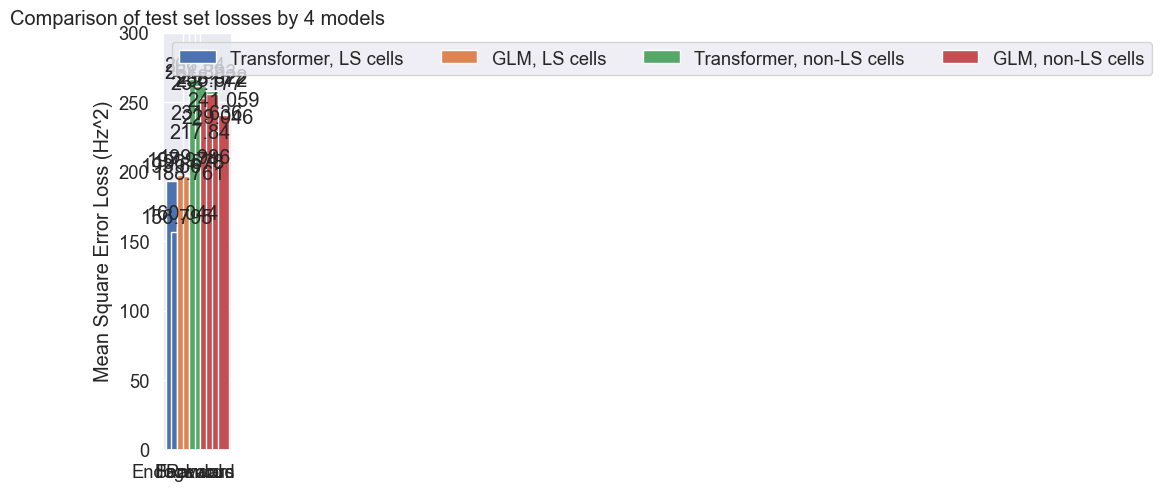

In [75]:
stim_types = ['Endogenous', 'Forward', 'Backward', 'Random']
mses = {
    'Transformer, LS cells': (LS_test_pred_loss[non_stim_mse_idx].sum()/len(non_stim_mse_idx)/13,
                              LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/13,
                              LS_test_pred_loss[backward_mse_idx].sum()/len(backward_mse_idx)/13,
                              LS_test_pred_loss[random_mse_idx].sum()/len(random_mse_idx)/13),
    'GLM, LS cells': (glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13,
                      glm_LS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/13,
                      glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/13,
                      glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/13),
    'Transformer, non-LS cells': (nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
                                  nLS_test_pred_loss[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                                  nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                                  nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/64),
    'GLM, non-LS cells': (glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
                          glm_nLS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                          glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                          glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/64)
}

x = np.arange(len(stim_types))
width = 2  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for model, loss in mses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, loss, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Square Error Loss (Hz^2)')
ax.set_title('Comparison of test set losses by 4 models')
ax.set_xticks(x + width, stim_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 300)

plt.show()


#### Violin plot